### Instalando e Importando Bibliotecas

In [1]:
pip install sqlalchemy cx_Oracle threadpoolctl==3.1.0 xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade scipy

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install azure-storage-blob pyarrow

Note: you may need to restart the kernel to use updated packages.


In [36]:
from sqlalchemy import create_engine
import cx_Oracle
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report, mean_absolute_error, confusion_matrix, roc_curve, auc, accuracy_score,ConfusionMatrixDisplay
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from azure.storage.blob import BlobServiceClient
from io import BytesIO
import gc
import pickle
import streamlit as st

### Criando a Conexão com o DB

In [7]:
#Conexão
usuario = 'RM564689'
senha = '010997'
host = 'ORACLE.FIAP.COM.BR' 
porta = '1521'
servico = 'ORCL'

conexao = create_engine(f"oracle+cx_oracle://{usuario}:{senha}@{host}/?service_name={servico}")

### Adicionando dados de feriado ao Dataset (flag perto_feriado)

In [8]:
query_feriados = """
SELECT cb_tickets.*,
    CASE 
        WHEN EXISTS (
            SELECT 1 FROM cb_feriados f 
            WHERE f.data_feriado > TO_DATE(cb_tickets.data_compra , 'YYYY-MM-DD')
              AND f.data_feriado <= TO_DATE(cb_tickets.data_compra, 'YYYY-MM-DD') + INTERVAL '7' day
        ) THEN 'Sim'
        ELSE 'Não'
    END AS perto_feriado
FROM cb_tickets
"""

df_cb = pd.read_sql(query_feriados, conexao)

### Análise inicial

In [9]:
df_cb.head()

,id_compra,id_cliente,data_compra,hora_compra,origem_ida,destino_ida,origem_volta,destino_volta,viacao_ida,viacao_volta,vl_total_compra,qnt_passagem_compra,perto_feriado
0,dece771bbc04a66d33545fb7f5795c65d28a9d986ad2cb...,3cd162cb7e26ce356f35b6b9507e6d41649c02e3dcfae5...,2023-03-23,15:47:00,ca9ceb6158f6b3bb85d1dd150d647de101e584146cf45e...,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,0,0,96061e92f58e4bdcdee73df36183fe3ac64747c81c26f6...,1,258.72,1,Não
1,70adcabcff818c647554391a3b36f354d920302907c731...,70047fcbe5b3a1cdfd8705326b41ca53848649f843d098...,2023-03-29,16:21:21,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,bfabb6cf02daa6bf1d9e91c5d141f55e38b8460af403bc...,0,0,96061e92f58e4bdcdee73df36183fe3ac64747c81c26f6...,1,82.69,1,Não
2,cb448eeb86ab1038334b4c0ad619b8fc1d41fc8484cfd8...,be1707c829d65f384dd3159852abdf43476609292fe785...,2023-03-02,21:49:09,4652614c4d8778e57a970722f142d832798c133a14b123...,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,0,0,35135aaa6cc23891b40cb3f378c53a17a1127210ce60e1...,1,41.73,1,Não
3,510ce3c7b998c629aa5fb9be2d15013891d5760b86fc9c...,4b91b36e1df2ea643c95b25df0700bd85eee2fb2211521...,2018-08-09,19:26:20,62f77e7d6197863ac98d9e0cfa76bea0c8e05379ed5281...,eb624dbe56eb6620ae62080c10a273cab73ae8eca98ab1...,0,0,59e19706d51d39f66711c2653cd7eb1291c94d9b55eb14...,1,47.2,1,Não
4,82f94bf39bbd077fb0987f8677c1cb8b5a80840079c944...,cd90f16597e597e588968efb967a3b2f32824d62f83a89...,2023-01-12,22:24:33,56f4da26ed956730309fa1488611ee0f13b0ac95ebb1bc...,284de502c9847342318c17d474733ef468fbdbe252cddf...,0,0,6f4b6612125fb3a0daecd2799dfd6c9c299424fd920f9b...,1,31.76,1,Não


In [10]:
df_cb.columns

Index(['id_compra', 'id_cliente', 'data_compra', 'hora_compra', 'origem_ida',
       'destino_ida', 'origem_volta', 'destino_volta', 'viacao_ida',
       'viacao_volta', 'vl_total_compra', 'qnt_passagem_compra',
       'perto_feriado'],
      dtype='object')

In [11]:
df_cb.dtypes

id_compra              object
id_cliente             object
data_compra            object
hora_compra            object
origem_ida             object
destino_ida            object
origem_volta           object
destino_volta          object
viacao_ida             object
viacao_volta           object
vl_total_compra        object
qnt_passagem_compra    object
perto_feriado          object
dtype: object

In [12]:
df_cb.shape

(1741344, 13)

In [13]:
df_cb.isnull().sum()

id_compra              0
id_cliente             0
data_compra            0
hora_compra            0
origem_ida             0
destino_ida            0
origem_volta           0
destino_volta          0
viacao_ida             0
viacao_volta           0
vl_total_compra        0
qnt_passagem_compra    0
perto_feriado          0
dtype: int64

In [14]:
df_cb.duplicated().sum()

0

### Transformando tipos dos dados

In [15]:
df_cb['data_compra'] = pd.to_datetime(df_cb['data_compra'], format='%Y-%m-%d')
df_cb['vl_total_compra'] = df_cb['vl_total_compra'].astype(float)
df_cb['qnt_passagem_compra'] = df_cb['qnt_passagem_compra'].astype('Int64')


In [16]:
df_cb.dtypes

id_compra                      object
id_cliente                     object
data_compra            datetime64[ns]
hora_compra                    object
origem_ida                     object
destino_ida                    object
origem_volta                   object
destino_volta                  object
viacao_ida                     object
viacao_volta                   object
vl_total_compra               float64
qnt_passagem_compra             Int64
perto_feriado                  object
dtype: object

### Criando coluna de quantidade de passageiros e flag viaja_sozinho

In [17]:
condicao = (df_cb['origem_volta'] != 0) & (df_cb['qnt_passagem_compra'] % 2 == 0)

df_cb['qnt_passageiros'] = np.where(
    condicao,
    df_cb['qnt_passagem_compra'] // 2,
    df_cb['qnt_passagem_compra']
)

In [18]:
df_cb['viaja_sozinho'] = df_cb['qnt_passageiros'].apply(lambda x : "Sim" if x == 1 else "Não")

In [19]:
df_cb.head()

,id_compra,id_cliente,data_compra,hora_compra,origem_ida,destino_ida,origem_volta,destino_volta,viacao_ida,viacao_volta,vl_total_compra,qnt_passagem_compra,perto_feriado,qnt_passageiros,viaja_sozinho
0,dece771bbc04a66d33545fb7f5795c65d28a9d986ad2cb...,3cd162cb7e26ce356f35b6b9507e6d41649c02e3dcfae5...,2023-03-23,15:47:00,ca9ceb6158f6b3bb85d1dd150d647de101e584146cf45e...,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,0,0,96061e92f58e4bdcdee73df36183fe3ac64747c81c26f6...,1,258.72,1,Não,1,Sim
1,70adcabcff818c647554391a3b36f354d920302907c731...,70047fcbe5b3a1cdfd8705326b41ca53848649f843d098...,2023-03-29,16:21:21,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,bfabb6cf02daa6bf1d9e91c5d141f55e38b8460af403bc...,0,0,96061e92f58e4bdcdee73df36183fe3ac64747c81c26f6...,1,82.69,1,Não,1,Sim
2,cb448eeb86ab1038334b4c0ad619b8fc1d41fc8484cfd8...,be1707c829d65f384dd3159852abdf43476609292fe785...,2023-03-02,21:49:09,4652614c4d8778e57a970722f142d832798c133a14b123...,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,0,0,35135aaa6cc23891b40cb3f378c53a17a1127210ce60e1...,1,41.73,1,Não,1,Sim
3,510ce3c7b998c629aa5fb9be2d15013891d5760b86fc9c...,4b91b36e1df2ea643c95b25df0700bd85eee2fb2211521...,2018-08-09,19:26:20,62f77e7d6197863ac98d9e0cfa76bea0c8e05379ed5281...,eb624dbe56eb6620ae62080c10a273cab73ae8eca98ab1...,0,0,59e19706d51d39f66711c2653cd7eb1291c94d9b55eb14...,1,47.20,1,Não,1,Sim
4,82f94bf39bbd077fb0987f8677c1cb8b5a80840079c944...,cd90f16597e597e588968efb967a3b2f32824d62f83a89...,2023-01-12,22:24:33,56f4da26ed956730309fa1488611ee0f13b0ac95ebb1bc...,284de502c9847342318c17d474733ef468fbdbe252cddf...,0,0,6f4b6612125fb3a0daecd2799dfd6c9c299424fd920f9b...,1,31.76,1,Não,1,Sim


### Calcular métricas de intervalo e de valor da compra

In [20]:
def calcular_metricas_intervalo(df):

    df['data_compra'] = pd.to_datetime(df['data_compra'])
    
    # Calcular quantidade total de compras por cliente
    qtd_compras = df.groupby('id_cliente').size().reset_index(name='qtd_total_compras')
    
    # Calcular intervalo médio
    df_sorted = df[['id_cliente', 'data_compra']].sort_values(['id_cliente', 'data_compra'])

    # Calcular diferença entre compras consecutivas do mesmo cliente
    df_sorted['data_anterior'] = df_sorted.groupby('id_cliente')['data_compra'].shift(1)
    df_sorted['intervalo_dias'] = (df_sorted['data_compra'] - df_sorted['data_anterior']).dt.days
    
    
    # Calcular estatísticas dos intervalos por cliente
    intervalos_stats = df_sorted.groupby('id_cliente')['intervalo_dias'].agg(['mean', 'min', 'max']).reset_index()
    
    intervalos_stats.columns = ['id_cliente', 'intervalo_medio_dias', 'intervalo_minimo_dias', 'intervalo_maximo_dias']
    
    # Arredondar os valores
    intervalos_stats['intervalo_medio_dias'] = intervalos_stats['intervalo_medio_dias'].round(2)
    intervalos_stats['intervalo_minimo_dias'] = intervalos_stats['intervalo_minimo_dias'].astype('Int64') 
    intervalos_stats['intervalo_maximo_dias'] = intervalos_stats['intervalo_maximo_dias'].astype('Int64')  
    
    # Combinar as métricas
    metricas = qtd_compras.merge(intervalos_stats, on='id_cliente', how='left')
    
    # Fazer merge com DataFrame original
    df_final = df.merge(metricas, on='id_cliente', how='left')
    
    return df_final

In [21]:
df_cb_metricas = calcular_metricas_intervalo(df_cb)

In [22]:
def calcular_metricas_valor(df):
    
    # Calcular valor médio
    df_sorted = df[['id_cliente', 'vl_total_compra']].sort_values(['id_cliente', 'vl_total_compra'])

    # Calcular estatísticas dos valores por cliente
    valores = df_sorted.groupby('id_cliente')['vl_total_compra'].agg(['mean']).reset_index()
    
    valores.columns = ['id_cliente', 'vl_medio_compra']
    
    # Arredondar os valores
    valores['vl_medio_compra'] = valores['vl_medio_compra'].round(2)

    # Juntar com DataFrame original
    df_final = df.merge(valores, on='id_cliente', how='left')
    
    return df_final

In [23]:
df_cb_metricas = calcular_metricas_valor(df_cb_metricas)

In [24]:
df_cb_metricas.head()

,id_compra,id_cliente,data_compra,hora_compra,origem_ida,destino_ida,origem_volta,destino_volta,viacao_ida,viacao_volta,vl_total_compra,qnt_passagem_compra,perto_feriado,qnt_passageiros,viaja_sozinho,qtd_total_compras,intervalo_medio_dias,intervalo_minimo_dias,intervalo_maximo_dias,vl_medio_compra
0,dece771bbc04a66d33545fb7f5795c65d28a9d986ad2cb...,3cd162cb7e26ce356f35b6b9507e6d41649c02e3dcfae5...,2023-03-23,15:47:00,ca9ceb6158f6b3bb85d1dd150d647de101e584146cf45e...,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,0,0,96061e92f58e4bdcdee73df36183fe3ac64747c81c26f6...,1,258.72,1,Não,1,Sim,3,42.0,0,84,178.58
1,70adcabcff818c647554391a3b36f354d920302907c731...,70047fcbe5b3a1cdfd8705326b41ca53848649f843d098...,2023-03-29,16:21:21,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,bfabb6cf02daa6bf1d9e91c5d141f55e38b8460af403bc...,0,0,96061e92f58e4bdcdee73df36183fe3ac64747c81c26f6...,1,82.69,1,Não,1,Sim,3,279.5,1,558,201.41
2,cb448eeb86ab1038334b4c0ad619b8fc1d41fc8484cfd8...,be1707c829d65f384dd3159852abdf43476609292fe785...,2023-03-02,21:49:09,4652614c4d8778e57a970722f142d832798c133a14b123...,d4735e3a265e16eee03f59718b9b5d03019c07d8b6c51f...,0,0,35135aaa6cc23891b40cb3f378c53a17a1127210ce60e1...,1,41.73,1,Não,1,Sim,2,0.0,0,0,62.60
3,510ce3c7b998c629aa5fb9be2d15013891d5760b86fc9c...,4b91b36e1df2ea643c95b25df0700bd85eee2fb2211521...,2018-08-09,19:26:20,62f77e7d6197863ac98d9e0cfa76bea0c8e05379ed5281...,eb624dbe56eb6620ae62080c10a273cab73ae8eca98ab1...,0,0,59e19706d51d39f66711c2653cd7eb1291c94d9b55eb14...,1,47.20,1,Não,1,Sim,3,957.0,2,1912,59.39
4,82f94bf39bbd077fb0987f8677c1cb8b5a80840079c944...,cd90f16597e597e588968efb967a3b2f32824d62f83a89...,2023-01-12,22:24:33,56f4da26ed956730309fa1488611ee0f13b0ac95ebb1bc...,284de502c9847342318c17d474733ef468fbdbe252cddf...,0,0,6f4b6612125fb3a0daecd2799dfd6c9c299424fd920f9b...,1,31.76,1,Não,1,Sim,1,NaN,<NA>,<NA>,31.76


## Desafio 1 - Perfil de Compra

### Preparo do dataset para treino

In [25]:
# Codificar variáveis categóricas
label_encoder = LabelEncoder()
df_cb_metricas['viaja_sozinho_n'] = df_cb_metricas['viaja_sozinho'].map({'Sim': 1, 'Não': 0})
df_cb_metricas['perto_feriado_n'] = df_cb_metricas['perto_feriado'].map({'Sim': 1, 'Não': 0})

# Selecionar colunas para o clustering
colunas_cluster = [
    'viaja_sozinho_n',
    'perto_feriado_n',
    'qtd_total_compras',
    'intervalo_medio_dias',
]

df_cb_metricas_cliente = df_cb_metricas.fillna(0).groupby('id_cliente')[colunas_cluster].mean()
X = df_cb_metricas_cliente

# Padronizar os dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Método do cotovelo indica que o número ideal de clusters é entre 4 e 5

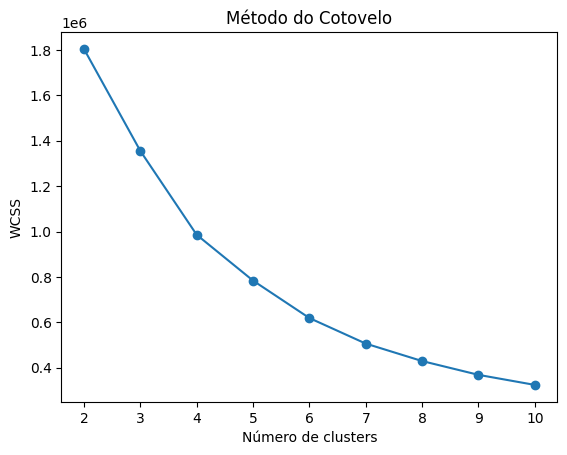

In [26]:
wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plotar gráfico do cotovelo
plt.plot(range(2, 11), wcss, marker='o')
plt.xlabel('Número de clusters')
plt.ylabel('WCSS')
plt.title('Método do Cotovelo')
plt.show()

### Treinando o modelo de clusterização

In [27]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_cb_metricas_cliente['cluster'] = kmeans.fit_predict(X_scaled)

In [28]:
# Médias de cada grupo
print(df_cb_metricas_cliente.groupby('cluster')[colunas_cluster].mean())

# Contagem de clientes por grupo
print(df_cb_metricas_cliente['cluster'].value_counts())

         viaja_sozinho_n  perto_feriado_n  qtd_total_compras  \
cluster                                                        
0               0.989186         0.055810           3.572474   
1               0.989386         0.854047           1.935415   
2               0.924397         0.271712           2.531031   
3               0.108183         0.267752           1.619099   

         intervalo_medio_dias  
cluster                        
0                   55.106382  
1                   54.779003  
2                 1055.210592  
3                   55.093318  
0    373322
1    136424
3     42536
2     29535
Name: cluster, dtype: int64


In [29]:
#renomeando clusters
cluster_map = {0: 'Sozinho_DiaComum', 1: 'Sozinho_Feriado', 2 : 'Infrequente', 3: 'Grupo'}
df_cb_metricas_cliente['cluster_name'] = df_cb_metricas_cliente['cluster'].map(cluster_map)


### Visualizando os resultados

C:\Users\Giovanna\anaconda3\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


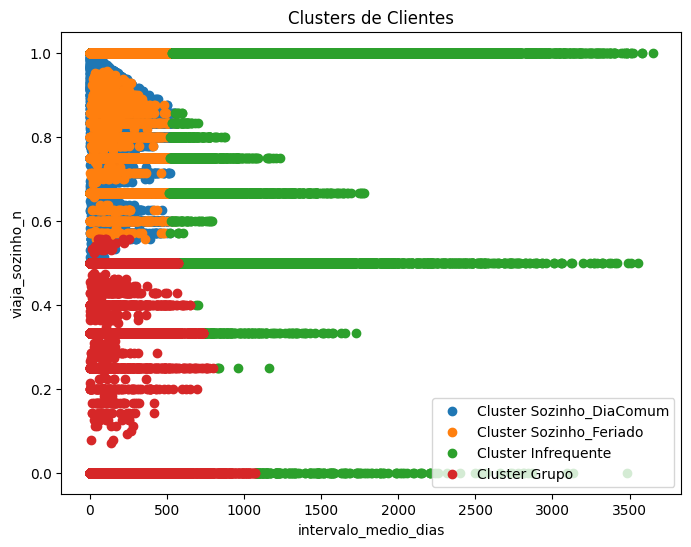

In [30]:
# Escolher 2 variáveis para plotar (por exemplo, valor compra x qtd viagens)
x_col = 'intervalo_medio_dias'
y_col = 'viaja_sozinho_n'
k=4
plt.figure(figsize=(8,6))
for cluster in range(k):
    cluster_data = df_cb_metricas_cliente[df_cb_metricas_cliente['cluster'] == cluster]
    plt.scatter(cluster_data[x_col], cluster_data[y_col], label=f'Cluster {cluster_map[cluster]}')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('Clusters de Clientes')
plt.legend()
plt.show()

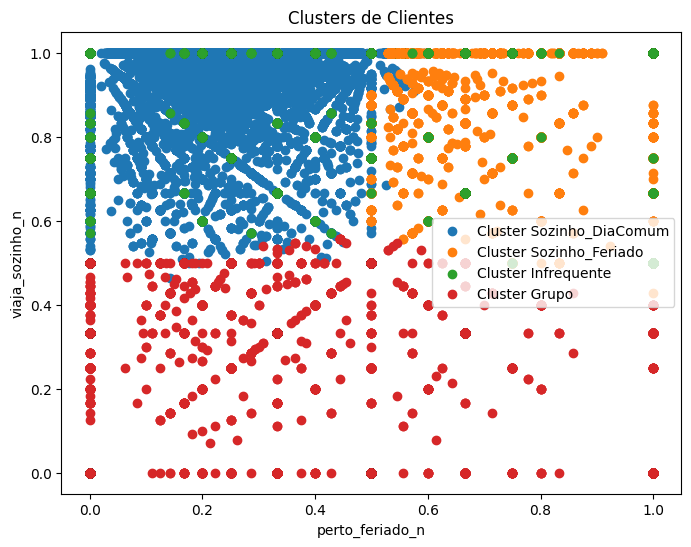

In [31]:
# Escolher 2 variáveis para plotar (por exemplo, valor compra x qtd viagens)
x_col = 'perto_feriado_n'
y_col = 'viaja_sozinho_n'

plt.figure(figsize=(8,6))
for cluster in range(k):
    cluster_data = df_cb_metricas_cliente[df_cb_metricas_cliente['cluster'] == cluster]
    plt.scatter(cluster_data[x_col], cluster_data[y_col], label=f'Cluster {cluster_map[cluster]}')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('Clusters de Clientes')
plt.legend()
plt.show()

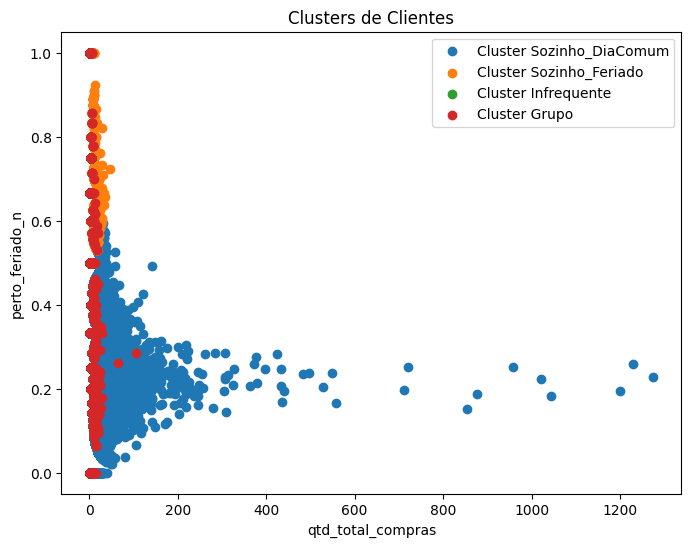

In [32]:
# Escolher 2 variáveis para plotar (por exemplo, valor compra x qtd viagens)
x_col = 'qtd_total_compras'
y_col = 'perto_feriado_n'

plt.figure(figsize=(8,6))
for cluster in range(k):
    cluster_data = df_cb_metricas_cliente[df_cb_metricas_cliente['cluster'] == cluster]
    plt.scatter(cluster_data[x_col], cluster_data[y_col], label=f'Cluster {cluster_map[cluster]}')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('Clusters de Clientes')
plt.legend()
plt.show()

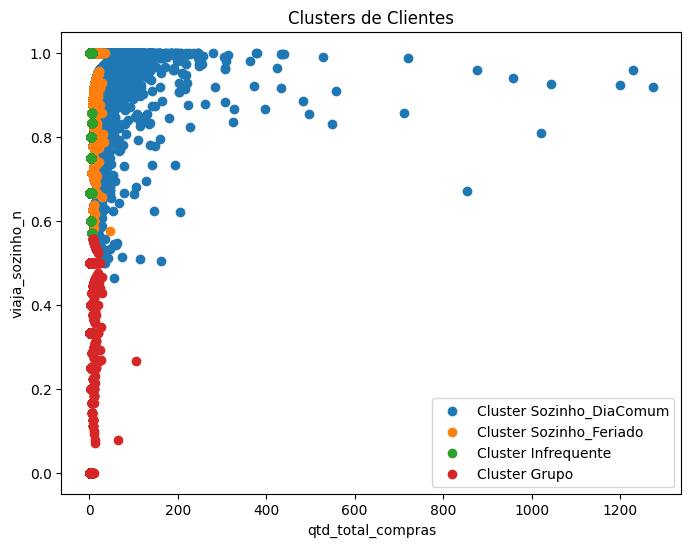

In [33]:
# Escolher 2 variáveis para plotar (por exemplo, valor compra x qtd viagens)
x_col = 'qtd_total_compras'
y_col = 'viaja_sozinho_n'

plt.figure(figsize=(8,6))
for cluster in range(k):
    cluster_data = df_cb_metricas_cliente[df_cb_metricas_cliente['cluster'] == cluster]
    plt.scatter(cluster_data[x_col], cluster_data[y_col], label=f'Cluster {cluster_map[cluster]}')

plt.xlabel(x_col)
plt.ylabel(y_col)
plt.title('Clusters de Clientes')
plt.legend()
plt.show()

## Desafio 2 - Prever próxima compra

### Adicionando novas métricas de data e comportamento de compra

In [34]:
df_cb_metricas['data_compra'] = pd.to_datetime(df_cb_metricas['data_compra'], errors='coerce')

df_metricas_previsao = df_cb_metricas.sort_values(['id_cliente', 'data_compra'])
df_metricas_previsao['dias_desde_ultima_compra'] = df_metricas_previsao.groupby('id_cliente')['data_compra'].diff().dt.days
df_metricas_previsao['dias_desde_ultima_compra'] = df_metricas_previsao['dias_desde_ultima_compra']\
.fillna(df_metricas_previsao['dias_desde_ultima_compra'].max())

# Features temporais

df_metricas_previsao['dia_semana'] = df_metricas_previsao['data_compra'].dt.weekday 
df_metricas_previsao['mes_compra'] = df_metricas_previsao['data_compra'].dt.month
df_metricas_previsao['ano_compra'] = df_metricas_previsao['data_compra'].dt.year
df_metricas_previsao['compra_fim_semana'] = df_metricas_previsao['dia_semana'].isin([5, 6]).astype(int)

# Estatísticas históricas do cliente

df_metricas_previsao['vl_max_compra'] = df_metricas_previsao.groupby('id_cliente')['vl_total_compra'].transform('max')
df_metricas_previsao['vl_min_compra'] = df_metricas_previsao.groupby('id_cliente')['vl_total_compra'].transform('min')

# Quantidade de destinos únicos já visitados
df_metricas_previsao['destinos_unicos'] = df_metricas_previsao.groupby('id_cliente')['destino_ida'].transform('nunique')

# Quantidade de empresas diferentes utilizadas
df_metricas_previsao['viacao_unica'] = df_metricas_previsao.groupby('id_cliente')['viacao_ida'].transform('nunique')

# Indicador de alta temporada
df_metricas_previsao['alta_temporada'] = df_metricas_previsao['mes_compra'].isin([6, 7, 12, 1]).astype(int)

# Valor acumulado histórico do cliente
df_metricas_previsao['valor_acumulado_compra'] = df_metricas_previsao.groupby('id_cliente')['vl_total_compra'].transform('sum')

# Recência (tempo desde a última compra até a data mais recente)
max_data = df_metricas_previsao['data_compra'].max()
df_metricas_previsao['recencia_dias'] = (max_data - df_metricas_previsao['data_compra']).dt.days


### Preparando o dataset e treinando o modelo

In [77]:
df_metricas_previsao['data_compra'] = pd.to_datetime(df_metricas_previsao['data_compra'])
df_previsao = df_metricas_previsao.sort_values(by=['id_cliente', 'data_compra']).reset_index(drop=True)
# Calcular próxima compra e diferença em dias
df_previsao['data_proxima_compra'] = df_previsao.groupby('id_cliente')['data_compra'].shift(-1)
df_previsao['dias_proxima_compra'] = (df_previsao['data_proxima_compra'] - df_previsao['data_compra']).dt.days

# Targets binários
df_previsao['janela_7d'] = np.where((df_previsao['dias_proxima_compra'] <= 7) & (df_previsao['dias_proxima_compra'] > 0), 1, 0)
df_previsao['janela_30d'] = np.where((df_previsao['dias_proxima_compra'] <= 30) & (df_previsao['dias_proxima_compra'] > 0), 1, 0)

# Remover últimas compras (sem próxima compra)
df_model = df_previsao.dropna(subset=['dias_proxima_compra'])

# Features para modelagem
colunas = [
    'viaja_sozinho_n',
    'perto_feriado_n',
    'qtd_total_compras',
    'intervalo_medio_dias',
    'vl_medio_compra',
    'dias_desde_ultima_compra',
    'destinos_unicos',
    'recencia_dias'
]


X = df_model[colunas]
y7 = df_model['janela_7d']
y30 = df_model['janela_30d']

# Separar treino/teste mantendo ordem temporal
split_index = int(len(df_model) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train7, y_test7 = y7.iloc[:split_index], y7.iloc[split_index:]
y_train30, y_test30 = y30.iloc[:split_index], y30.iloc[split_index:]

# Modelo XGBoost (7 dias)
xgb7 = XGBClassifier(random_state=42, eval_metric='logloss')
xgb7.fit(X_train, y_train7)
print("XGBoost - 7 dias")
print(classification_report(y_test7, xgb7.predict(X_test)))
    
# XGBoost (30 dias)
xgb30 = XGBClassifier(random_state=42, eval_metric='logloss')
xgb30.fit(X_train, y_train30)
print("XGBoost - 30 dias")
print(classification_report(y_test30, xgb30.predict(X_test)))

# Prever dias até próxima compra 
y_days = df_model['dias_proxima_compra']

X_train_r, X_test_r = X.iloc[:split_index], X.iloc[split_index:]
y_train_r, y_test_r = y_days.iloc[:split_index], y_days.iloc[split_index:]

# XGBoost Regressor
xgb_reg = XGBRegressor(random_state=42)
xgb_reg.fit(X_train_r, y_train_r)
y_pred_xgb_r = xgb_reg.predict(X_test_r)
print("XGBoost Regressor - MAE:", mean_absolute_error(y_test_r, y_pred_xgb_r))

# Salvar o modelo 7 dias
with open('xgboost_model_7d.pkl', 'wb') as f:
    pickle.dump(xgb7, f)
# Salvar o modelo 30 dias
with open('xgboost_model_30d.pkl', 'wb') as f:
    pickle.dump(xgb30, f)
# Salvar o modelo dia exato
with open('xgboost_model_dia_exato.pkl', 'wb') as f:
    pickle.dump(xgb_reg, f)

XGBoost - 7 dias
              precision    recall  f1-score   support

           0       0.80      0.97      0.88    176741
           1       0.69      0.24      0.35     55165

    accuracy                           0.79    231906
   macro avg       0.75      0.60      0.61    231906
weighted avg       0.78      0.79      0.75    231906

XGBoost - 30 dias
              precision    recall  f1-score   support

           0       0.73      0.77      0.75    127053
           1       0.70      0.65      0.68    104853

    accuracy                           0.72    231906
   macro avg       0.72      0.71      0.71    231906
weighted avg       0.72      0.72      0.72    231906

XGBoost Regressor - MAE: 86.16588749031344


### Visualizando os resultados

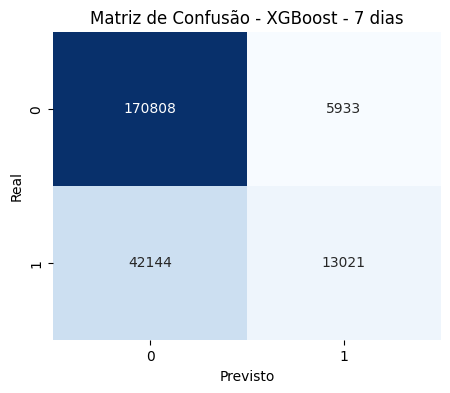

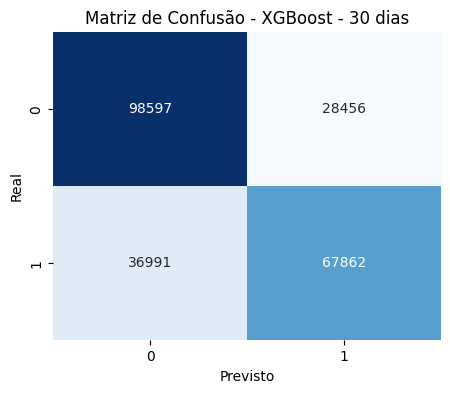

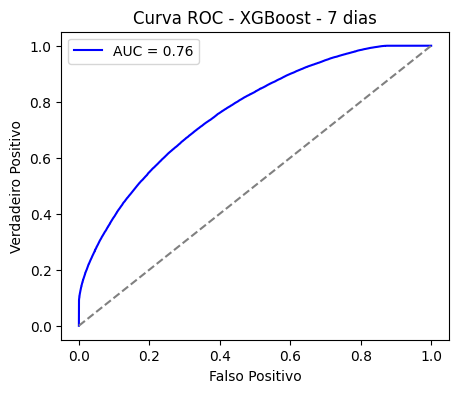

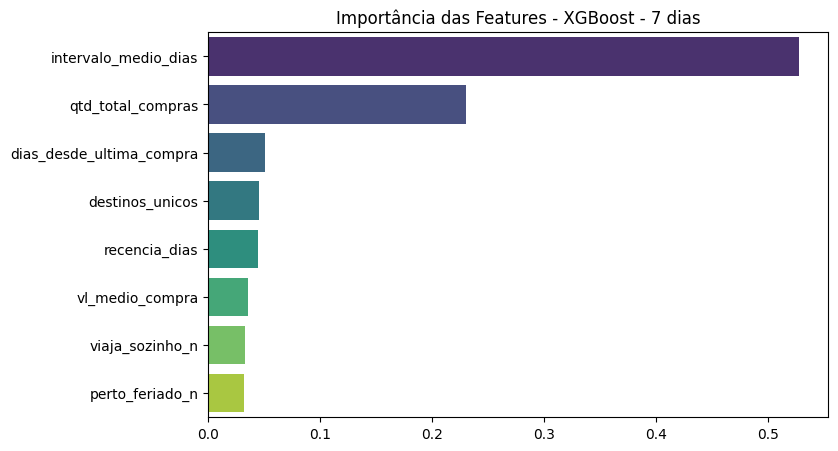

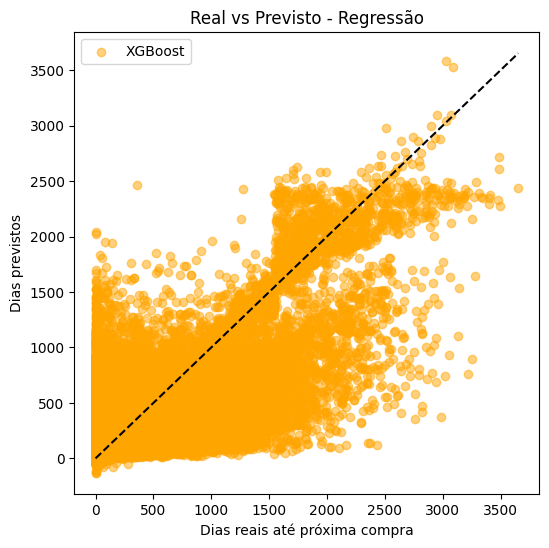

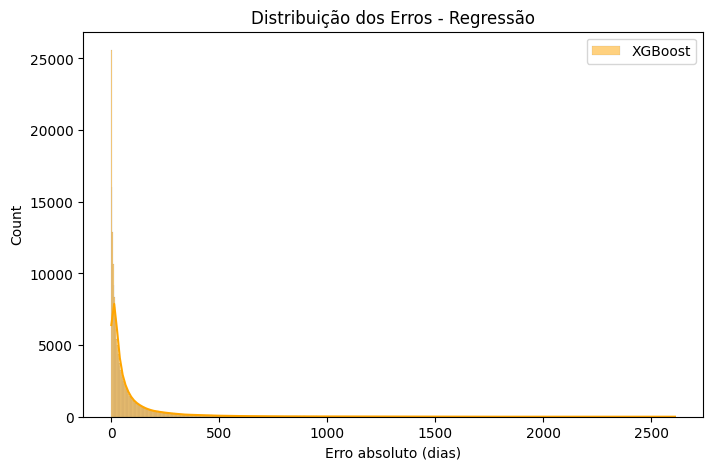

In [39]:
def plot_confusion_matrix(model, X_test, y_test, titulo):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Matriz de Confusão - {titulo}')
    plt.xlabel('Previsto')
    plt.ylabel('Real')
    plt.show()

plot_confusion_matrix(xgb7, X_test, y_test7, 'XGBoost - 7 dias')

plot_confusion_matrix(xgb30, X_test, y_test30, 'XGBoost - 30 dias')

def plot_roc(model, X_test, y_test, titulo):
    y_proba = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.title(f'Curva ROC - {titulo}')
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.legend()
    plt.show()
    
plot_roc(xgb7, X_test, y_test7, 'XGBoost - 7 dias')

def plot_feature_importance(model, X, titulo):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(8, 5))
    sns.barplot(x=importances[indices], y=X.columns[indices], palette="viridis")
    plt.title(f'Importância das Features - {titulo}')
    plt.show()

plot_feature_importance(xgb7, X, 'XGBoost - 7 dias')

plt.figure(figsize=(6, 6))
plt.scatter(y_test_r, y_pred_xgb_r, alpha=0.5, label='XGBoost', color='orange')
plt.plot([y_test_r.min(), y_test_r.max()], [y_test_r.min(), y_test_r.max()], 'k--')
plt.xlabel("Dias reais até próxima compra")
plt.ylabel("Dias previstos")
plt.title("Real vs Previsto - Regressão")
plt.legend()
plt.show()

erro_xgb = abs(y_test_r - y_pred_xgb_r)

plt.figure(figsize=(8, 5))
sns.histplot(erro_xgb, kde=True, color='orange', label='XGBoost')
plt.xlabel("Erro absoluto (dias)")
plt.title("Distribuição dos Erros - Regressão")
plt.legend()
plt.show()

## Desafio 3 - Prever o próximo trecho

### Adicionar métricas de histórico de trecho

In [40]:
# Limpeza de memória
gc.collect()

# Criar coluna de classe (trecho)
df_cb['trecho_ida'] = df_cb['origem_ida'].astype(str) + '_' + df_cb['destino_ida'].astype(str)

# Função para criar features por cliente
def process_client_history(group):
    history_features = []

    for idx in range(len(group)):
        current_row = group.iloc[idx]

        # Pegar apenas viagens ANTERIORES à atual (evitar data leakage)
        previous_trips = group.iloc[:idx] if idx > 0 else pd.DataFrame()

        features = {
            'id_cliente': current_row['id_cliente'],
            'data_compra': current_row['data_compra'],
            'trecho_ida': current_row['trecho_ida']
        }

        if len(previous_trips) == 0:
            # Cliente novo - sem histórico
            features.update({
                'trecho_mais_visitado': 'NOVO_CLIENTE',
                'ultimo_trecho': 'NOVO_CLIENTE',
                'penultimo_trecho': 'NOVO_CLIENTE',
                'padrão_viagem': 'NOVO_CLIENTE'
            })
        else:
            # Cliente com histórico
            # Trechos mais visitados
            trechos_anteriores = previous_trips['trecho_ida'].tolist()
            if trechos_anteriores:
                trecho_counts = Counter(trechos_anteriores)
                features['trecho_mais_visitado'] = trecho_counts.most_common(1)[0][0]
            else:
                features['trecho_mais_visitado'] = 'NOVO_CLIENTE'

            # Últimos trechos visitados
            if len(trechos_anteriores) >= 1:
                features['ultimo_trecho'] = trechos_anteriores[-1]
            else:
                features['ultimo_trecho'] = 'NOVO_CLIENTE'

            if len(trechos_anteriores) >= 2:
                features['penultimo_trecho'] = trechos_anteriores[-2]
            else:
                features['penultimo_trecho'] = 'NOVO_CLIENTE'
            
            destinos_anteriores = previous_trips['destino_ida'].tolist()
            diversidade_destinos = len(set(destinos_anteriores))
            total_viagens = len(previous_trips)

            # Padrão de viagem (ida e volta vs sempre diferente)
            if len(set(trechos_anteriores)) == 1 and total_viagens > 1:
                features['padrão_viagem'] = 'REPETITIVO'
            elif diversidade_destinos == total_viagens:
                features['padrão_viagem'] = 'EXPLORADOR'
            else:
                features['padrão_viagem'] = 'MISTO'

        history_features.append(features)

    return pd.DataFrame(history_features)

result_list = []
df_sorted = df_cb.sort_values(['id_cliente', 'data_compra']).copy()
total_clients = df_sorted['id_cliente'].nunique()
for i, (client_id, group) in enumerate(df_sorted.groupby('id_cliente')):
    if i % 100000 == 0:
        print(f"Processando cliente {i+1}/{total_clients}")

    client_features = process_client_history(group)
    result_list.append(client_features)
    
# Criar dataset com features históricas
df_with_history = pd.concat(result_list, ignore_index=True)

print(f"Dataset com histórico criado: {len(df_with_history)} registros")

Processando cliente 1/581817
Processando cliente 100001/581817
Processando cliente 200001/581817
Processando cliente 300001/581817
Processando cliente 400001/581817
Processando cliente 500001/581817
Dataset com histórico criado: 1741344 registros


### Preparar o dataset e treinar o modelo
- Para reduzir o número de classes, foi aplicado um filtro para apenas trechos que foram comprados mais do que 7500 vezes, resultando em 16 classes. Trabalhar com um número elevado de classes resulta em um processamento muito custoso.
- Apenas a compra mais recente dos clientes foram utilizadas para evitar vazamento de dados, pois a coluna com histórico de compras pode enviesar o modelo 
- Apenas clientes com histórico de compras foram selecionados


In [41]:
# Criar coluna de classe (trecho)
df_metricas_previsao['trecho_ida'] = df_metricas_previsao['origem_ida'].astype(str) + '_' + df_metricas_previsao['destino_ida'].astype(str)
# Filtro para reduzir número de classes
print("Análise inicial das classes:")
classe_counts = df_metricas_previsao['trecho_ida'].value_counts()
trechos_validos = classe_counts[classe_counts > 7500].index
df_metricas_previsao_filtrado = df_metricas_previsao[df_metricas_previsao['trecho_ida'].isin(trechos_validos)]
classe_counts = df_metricas_previsao_filtrado['trecho_ida'].value_counts()
print(f"Total de classes únicas: {len(classe_counts)}")
print(f"Distribuição das frequências:")
print(classe_counts.describe())

# Juntar com métricas de cliente
df_modelo = df_with_history.merge(
    df_metricas_previsao_filtrado.reset_index(), 
    on='id_cliente', 
    how='inner'
)

df_modelo = df_modelo.drop(columns=['trecho_ida_x', 'data_compra_x'])
df_modelo = df_modelo.rename(columns={'trecho_ida_y': 'trecho_ida', 'data_compra_y':'data_compra'})

# Usar apenas a última compra de cada cliente para previsão (evitar data leakage)
df_ultima_compra = (
    df_modelo.sort_values('data_compra')
            .groupby('id_cliente')
            .tail(1)
            .copy()
)
numeric_features=[]
categorical_features=[]
# Features numéricas
for col in ['viaja_sozinho_n', 'perto_feriado_n', 'qtd_total_compras', 
            'destinos_unicos', 'intervalo_medio_dias', 'viacao_unica', 
            'alta_temporada', 'compra_fim_semana']:
    if col in df_ultima_compra.columns:
        numeric_features.append(col)

# Features categóricas (vamos fazer encoding)
for col in ['trecho_mais_visitado', 'ultimo_trecho', 'penultimo_trecho', 
            'padrão_viagem']:
    if col in df_ultima_compra.columns:
        categorical_features.append(col)

# Preparar dataset
df_modelo = df_ultima_compra.copy()

# Filtrar apenas registros com pelo menos 1 viagem anterior (para ter features históricas)
df_modelo = df_modelo[df_modelo['ultimo_trecho'] != 'NOVO_CLIENTE'].copy()

print(f"Dataset final (última compra por cliente): {len(df_ultima_compra)} registros")

# Encoding de features categóricas
encoders = {}
for col in categorical_features:
    if col in df_modelo.columns:
        le = LabelEncoder()
        df_modelo[f'{col}_encoded'] = le.fit_transform(df_modelo[col].astype(str))
        encoders[col] = le
        numeric_features.append(f'{col}_encoded')
        
print(f"Features numéricas: {numeric_features}")
print(f"Features categóricas: {categorical_features}")

# Separar features e target
X = df_modelo.drop(columns=['id_cliente', 'trecho_ida'])[numeric_features]
y = df_modelo['trecho_ida']

# Aplicar LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f"Dataset final: {len(X)} registros, {len(np.unique(y_encoded))} classes")

# Treino/teste
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_encoded
)

# Modelo 1: XGBoost com configurações otimizadas para memória

print("XGBOOST")

xgb_model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    objective='multi:softprob',
    tree_method='hist',
    subsample=0.9,         
    colsample_bytree=0.9, 
    max_bin=128,          
    n_estimators=500,     
    max_depth=12,
)
xgb_model.fit(X_train, y_train, verbose=True)
y_pred_xgb = xgb_model.predict(X_test)
print(f"XGBoost - Acurácia: {accuracy_score(y_test, y_pred_xgb):.4f}")

y_pred = xgb_model.predict(X_test)
print("Acurácia:", accuracy_score(y_test, y_pred))

# Relatório de classificação (limitado para não sobrecarregar)
if len(le.classes_) <= 20:
    print(classification_report(y_test, y_pred, target_names=le.classes_))
else:
    print("Muitas classes para mostrar relatório detalhado")
    
# Salvar o modelo
with open('xgboost_model_trecho.pkl', 'wb') as f:
    pickle.dump(xgb_model, f)

# Limpeza de memória
gc.collect()

Análise inicial das classes:
Total de classes únicas: 16
Distribuição das frequências:
count       16.000000
mean     14713.750000
std       9464.753059
min       7538.000000
25%       8852.000000
50%      10702.000000
75%      16188.500000
max      37879.000000
Name: trecho_ida, dtype: float64
Dataset final (última compra por cliente): 107564 registros
Features numéricas: ['viaja_sozinho_n', 'perto_feriado_n', 'qtd_total_compras', 'destinos_unicos', 'intervalo_medio_dias', 'viacao_unica', 'alta_temporada', 'compra_fim_semana', 'trecho_mais_visitado_encoded', 'ultimo_trecho_encoded', 'penultimo_trecho_encoded', 'padrão_viagem_encoded']
Features categóricas: ['trecho_mais_visitado', 'ultimo_trecho', 'penultimo_trecho', 'padrão_viagem']
Dataset final: 43616 registros, 16 classes
XGBOOST
XGBoost - Acurácia: 0.4831
Acurácia: 0.4831499312242091
                                                                                                                                   precision    reca

43

### Visualizando os resultados

C:\Users\Giovanna\AppData\Local\Temp\ipykernel_15640\2374062164.py:10: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


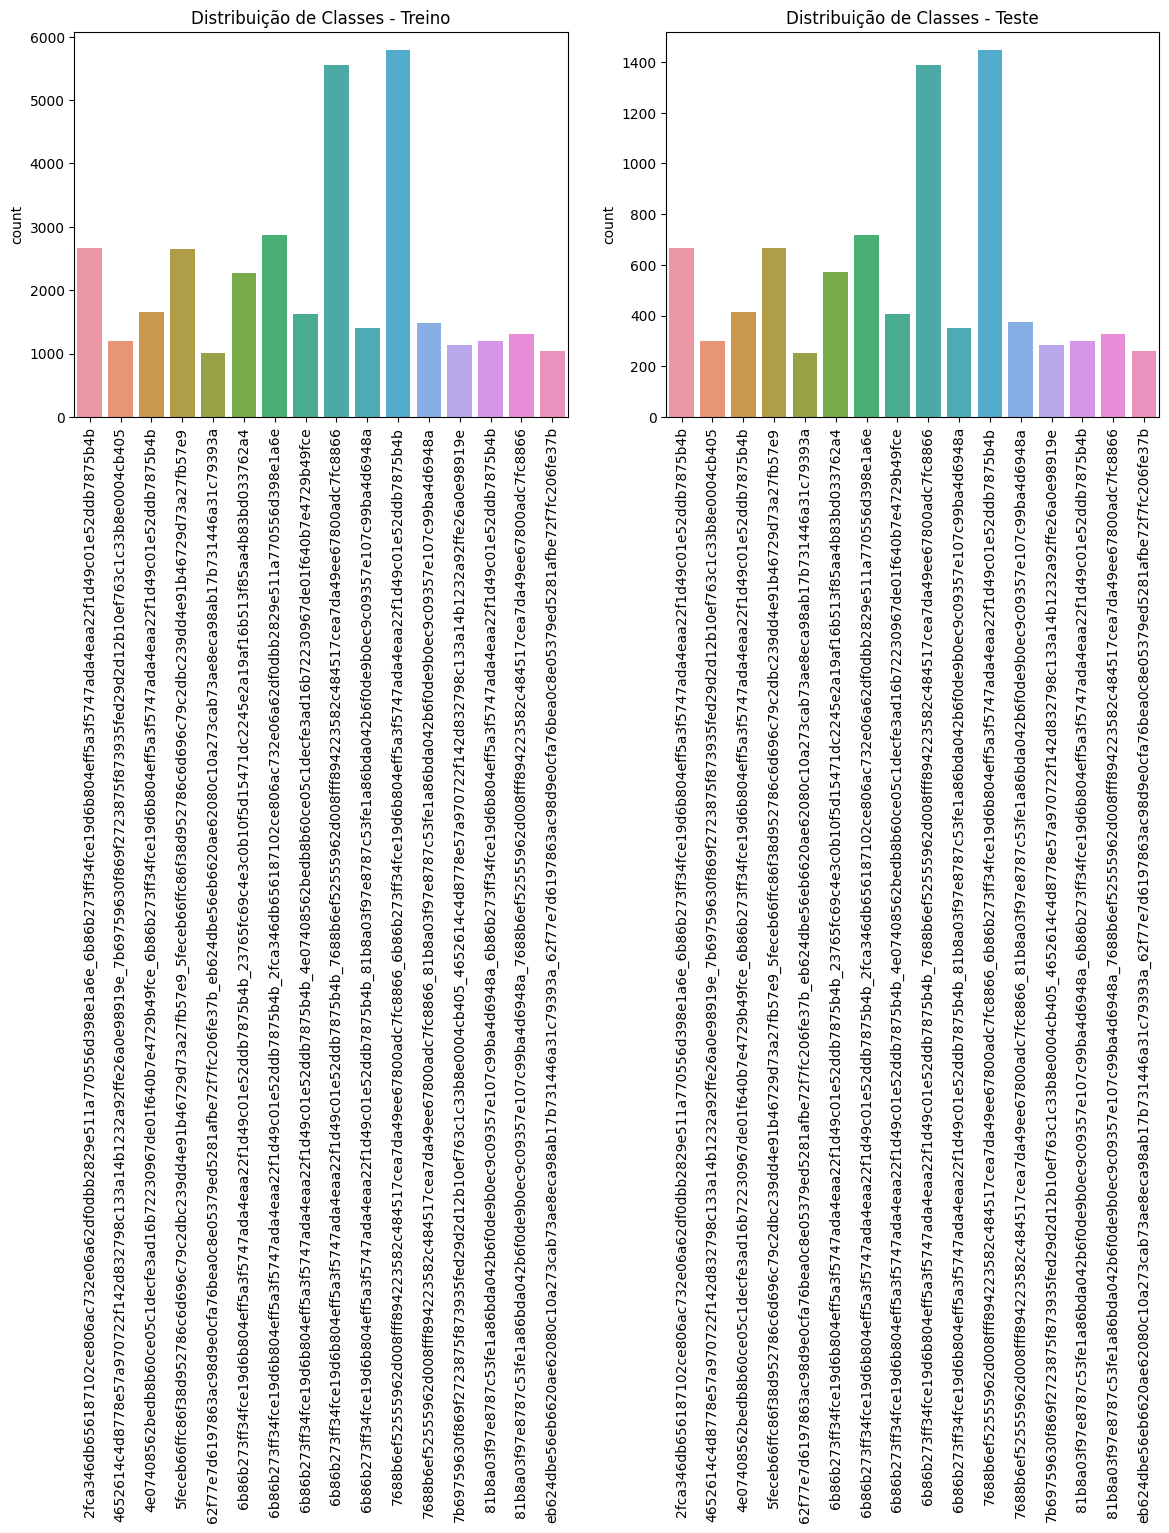

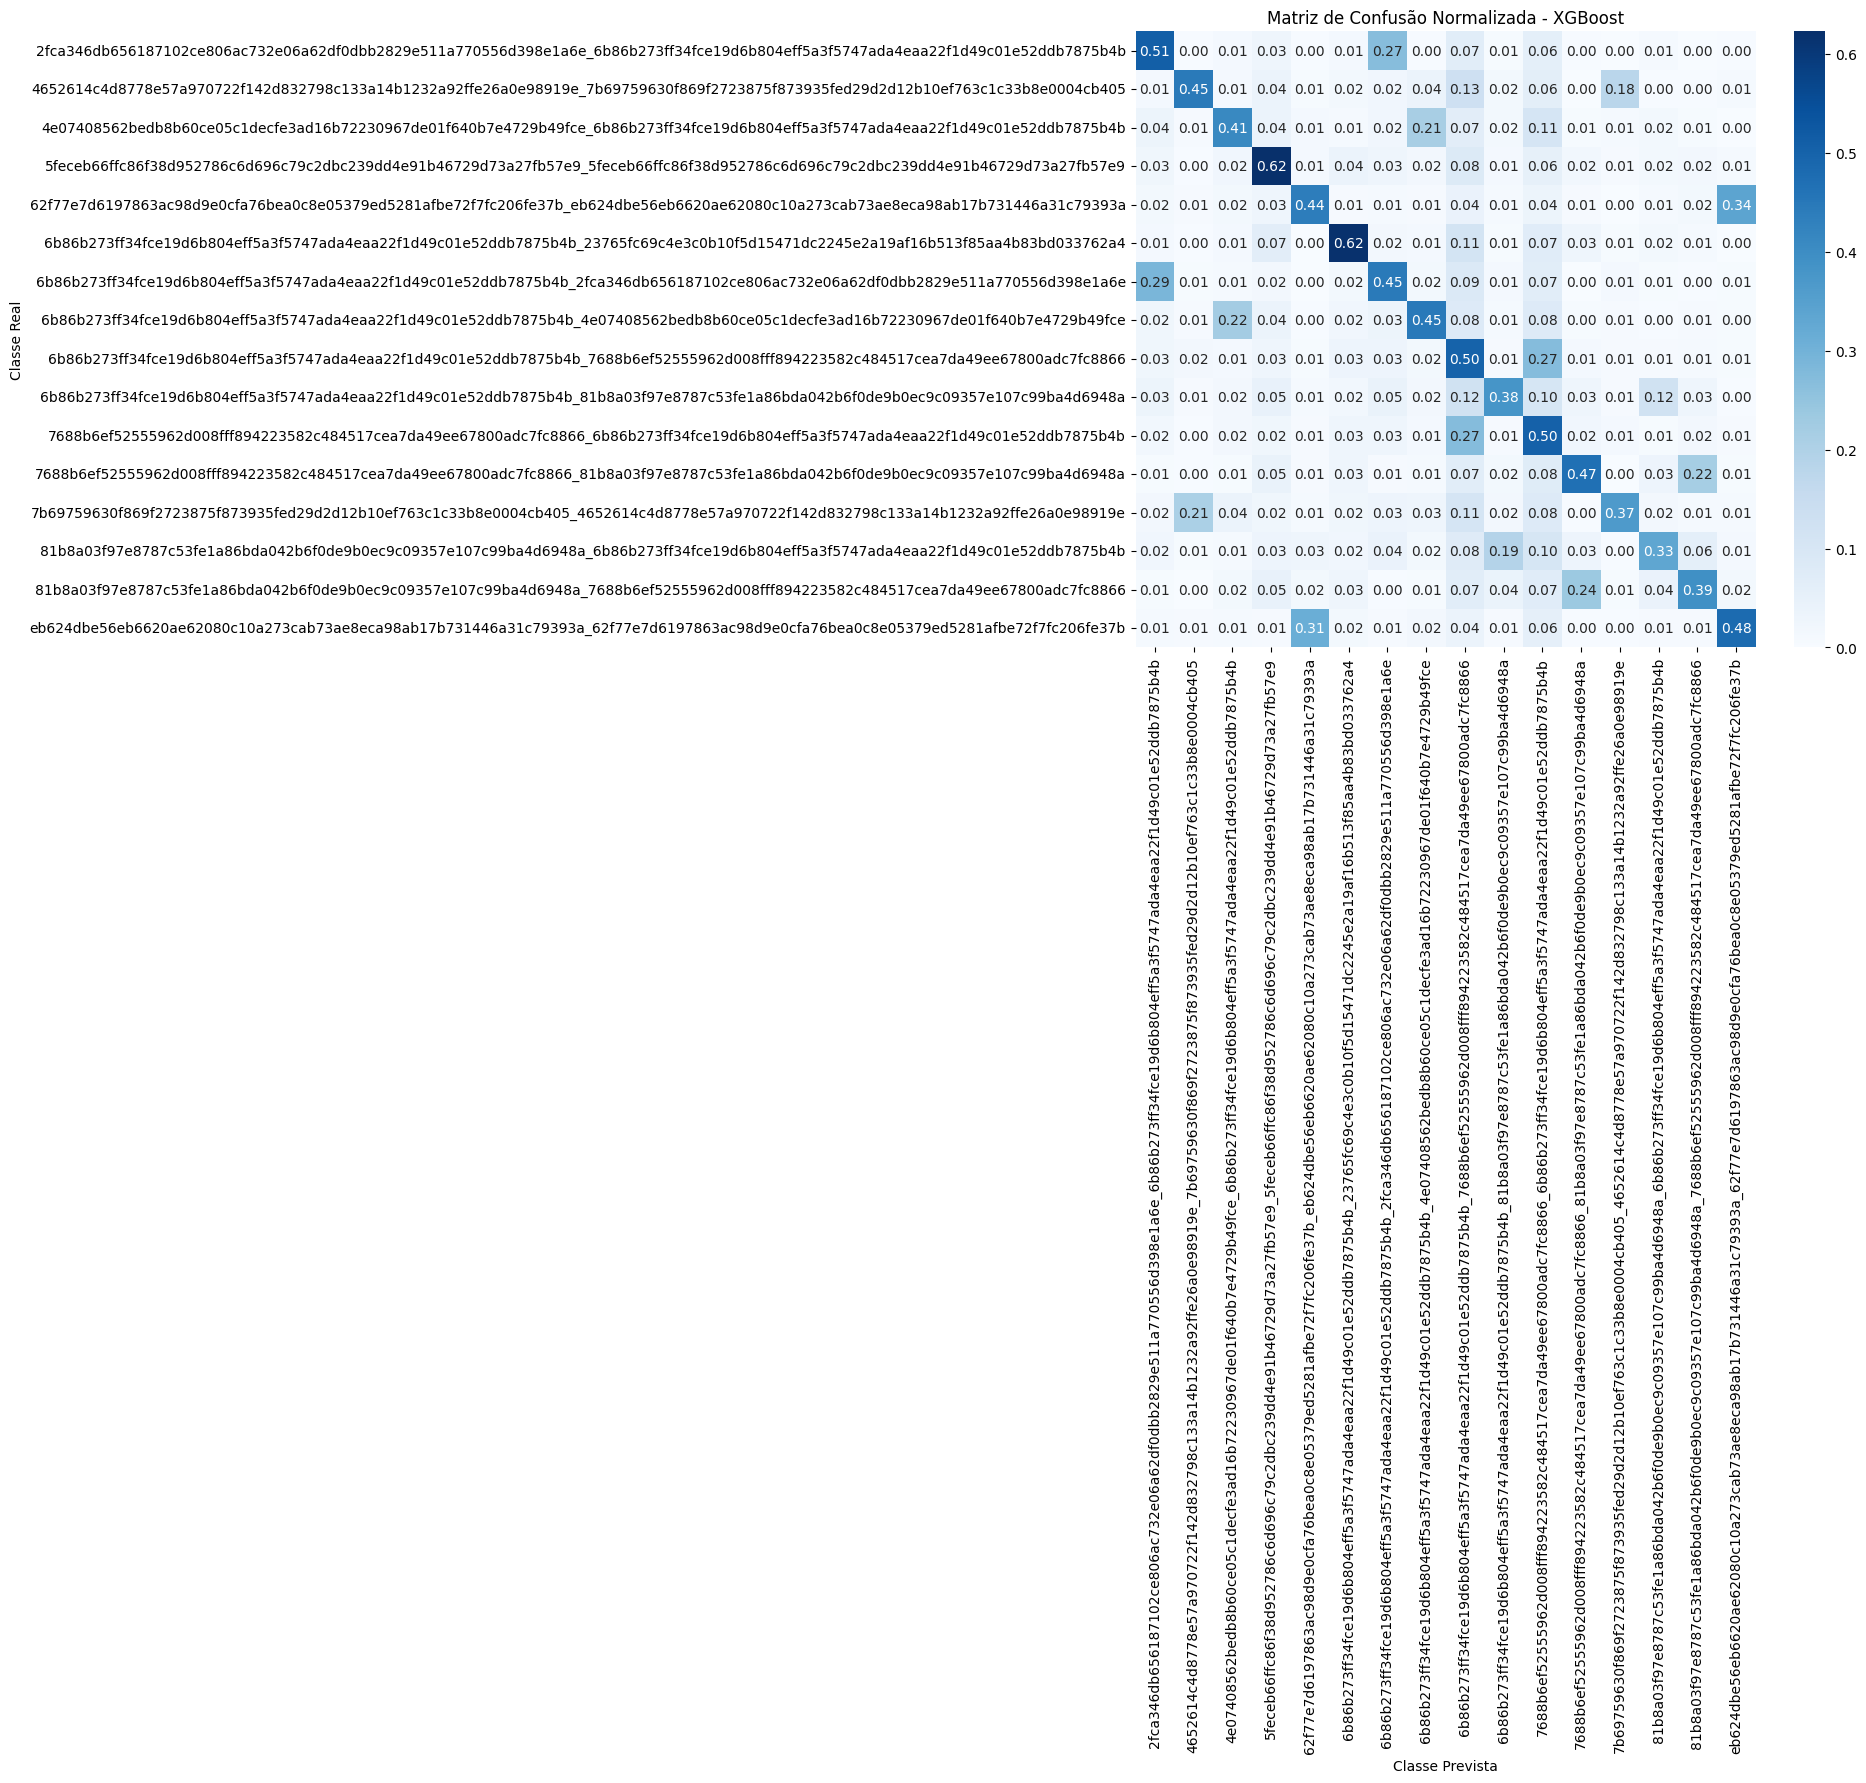

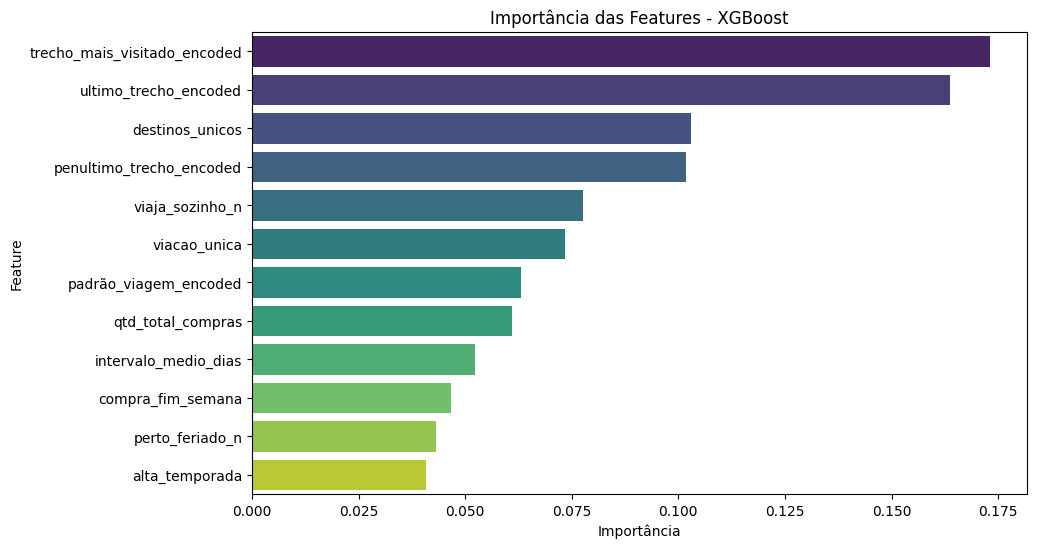

In [42]:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
sns.countplot(x=le.inverse_transform(y_train), order=np.unique(le.inverse_transform(y_train)), ax=ax[0])
ax[0].set_title('Distribuição de Classes - Treino')
ax[0].tick_params(axis='x', rotation=90)

sns.countplot(x=le.inverse_transform(y_test), order=np.unique(le.inverse_transform(y_test)), ax=ax[1])
ax[1].set_title('Distribuição de Classes - Teste')
ax[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

if len(le.classes_) <= 20:  # só mostra se não tiver muitas classes
    cm = confusion_matrix(y_test, y_pred_xgb, normalize='true')
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Matriz de Confusão Normalizada - XGBoost")
    plt.ylabel("Classe Real")
    plt.xlabel("Classe Prevista")
    plt.show()

importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=X.columns[indices], palette='viridis')
plt.title("Importância das Features - XGBoost")
plt.xlabel("Importância")
plt.ylabel("Feature")
plt.show()


## Persistir o resultado no Azure Blob Storage

### Adicionando a coluna cluster ao dataframe final

In [44]:
df_final = df_metricas_previsao.merge(df_cb_metricas_cliente[['cluster_name']],how='left',on=['id_cliente'])
print(df_final.columns)
df_final.head()

Index(['id_compra', 'id_cliente', 'data_compra', 'hora_compra', 'origem_ida',
       'destino_ida', 'origem_volta', 'destino_volta', 'viacao_ida',
       'viacao_volta', 'vl_total_compra', 'qnt_passagem_compra',
       'perto_feriado', 'qnt_passageiros', 'viaja_sozinho',
       'qtd_total_compras', 'intervalo_medio_dias', 'intervalo_minimo_dias',
       'intervalo_maximo_dias', 'vl_medio_compra', 'viaja_sozinho_n',
       'perto_feriado_n', 'dias_desde_ultima_compra', 'dia_semana',
       'mes_compra', 'ano_compra', 'compra_fim_semana', 'vl_max_compra',
       'vl_min_compra', 'destinos_unicos', 'viacao_unica', 'alta_temporada',
       'valor_acumulado_compra', 'recencia_dias', 'trecho_ida',
       'cluster_name'],
      dtype='object')


,id_compra,id_cliente,data_compra,hora_compra,origem_ida,destino_ida,origem_volta,destino_volta,viacao_ida,viacao_volta,...,compra_fim_semana,vl_max_compra,vl_min_compra,destinos_unicos,viacao_unica,alta_temporada,valor_acumulado_compra,recencia_dias,trecho_ida,cluster_name
0,a0f606b30e5661a1e5e5d2de8e2631ea06e862d65dffca...,0000029b76ad3cf9d86ad430754fb1d4478069affda61e...,2021-01-09,15:42:01,2fca346db656187102ce806ac732e06a62df0dbb2829e5...,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,0,0,620c9c332101a5bae955c66ae72268fbcd397276617952...,1,...,1,91.02,91.02,1,1,1,91.02,1178,2fca346db656187102ce806ac732e06a62df0dbb2829e5...,Sozinho_DiaComum
1,f836205b15754adbb0eb0788036f99cbae7b24e4ebdf0e...,000010ae2e13049769982d9f07de792d92452ff1d124e3...,2021-01-03,17:35:59,f369cb89fc627e668987007d121ed1eacdc01db9e28f8b...,5514a9f709310b22ee9bddd4e6da1b2b8b04d1ad5c3dcb...,0,0,811786ad1ae74adfdd20dd0372abaaebc6246e343aebd0...,1,...,1,82.48,79.52,2,2,1,162.00,1184,f369cb89fc627e668987007d121ed1eacdc01db9e28f8b...,Sozinho_DiaComum
2,5bce10182998dec6d78fc219b7ea702f3f06d9c39d51ce...,000010ae2e13049769982d9f07de792d92452ff1d124e3...,2022-05-05,15:38:52,62f77e7d6197863ac98d9e0cfa76bea0c8e05379ed5281...,eb624dbe56eb6620ae62080c10a273cab73ae8eca98ab1...,0,0,f369cb89fc627e668987007d121ed1eacdc01db9e28f8b...,1,...,0,82.48,79.52,2,2,0,162.00,697,62f77e7d6197863ac98d9e0cfa76bea0c8e05379ed5281...,Sozinho_DiaComum
3,74f9c0e388659f6074289974d1955ac75d35380e9aed05...,00001f68902d3e8d332baa62a69065ce71e7b5a8c850a5...,2018-11-01,08:11:08,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,fc72c98a6c2916c1bbf9f39fce094f5785bb6f1d656971...,0,0,9f14025af0065b30e47e23ebb3b491d39ae8ed17d33739...,1,...,0,169.90,169.90,1,1,0,169.90,1978,6b86b273ff34fce19d6b804eff5a3f5747ada4eaa22f1d...,Sozinho_Feriado
4,233345ad496e2fd9cd89feed99b030c227a352f505d502...,00007a5d618cd250d7f05766cfe01a8663a3767f1cd669...,2019-01-13,12:56:44,7688b6ef52555962d008fff894223582c484517cea7da4...,81b8a03f97e8787c53fe1a86bda042b6f0de9b0ec9c093...,0,0,35135aaa6cc23891b40cb3f378c53a17a1127210ce60e1...,1,...,1,233.88,131.49,4,3,1,688.48,1905,7688b6ef52555962d008fff894223582c484517cea7da4...,Sozinho_DiaComum


In [ ]:
account_name = "stgclickbuspythonrangers"
container_name = "cbdata-gold"
blob_name = "cbtickets_gold/dataframe.parquet"
sas_token = "sp=rw&st=2025-08-14T16:57:21Z&se=2025-10-23T01:12:21Z&spr=https&sv=2024-11-04&sr=c&sig=OY%2Fzdf%2F1Sfo4fNK4Sru94EVQb3mtNVNOqHjZiB0wplM%3D"

# Criar cliente
blob_client = BlobServiceClient(
    account_url=f"https://{account_name}.blob.core.windows.net",
    credential=sas_token
).get_blob_client(container=container_name, blob=blob_name)

# Converter DataFrame em Parquet na memória
parquet_buffer = BytesIO()
df_final.to_parquet(parquet_buffer, index=False, engine="pyarrow")

# Upload para o Azure Blob
blob_client.upload_blob(parquet_buffer.getvalue(), overwrite=True)

In [56]:
# Carregar datasets para arquivo CSV com objetivo de usar no streamlit
df_final[[
    'id_cliente',
    'viaja_sozinho_n',
    'perto_feriado_n',
    'qtd_total_compras',
    'intervalo_medio_dias',
    'vl_medio_compra',
    'dias_desde_ultima_compra',
    'destinos_unicos',
    'recencia_dias'  
]].to_csv('cb_previsao_data.csv', index=False, header=True)

# Carregar datasets para arquivo CSV com objetivo de usar no streamlit
df_modelo[[
    'id_cliente',
    'viaja_sozinho_n', 
    'perto_feriado_n', 
    'qtd_total_compras', 
    'destinos_unicos', 
    'intervalo_medio_dias', 
    'viacao_unica', 
    'alta_temporada', 
    'compra_fim_semana', 
    'trecho_mais_visitado_encoded', 
    'ultimo_trecho_encoded', 
    'penultimo_trecho_encoded', 
    'padrão_viagem_encoded'  
]].to_csv('cb_previsao_trecho.csv', index=False, header=True)

In [72]:
# Salvar as classes como CSV
pd.DataFrame(data=le.classes_,columns=['Trechos']).to_csv('classes.csv', index=False, header=True)